In [1]:
import os
import dotenv
from termcolor import colored
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from llm import LLM

dotenv.load_dotenv()
gpt35t = LLM("gpt-3.5-turbo")
gpt4 = LLM("gpt-4")

## 1. Make quadratic problems

In [ ]:
from make_quadratic_problems import make_quadratic_problem

dotenv.load_dotenv()
llm = LLM("gpt-3.5-turbo")

for max in range(5, 50, 5):
    for factorable in [True, False]:
        filename = f'data/quadratic_problems/quadratic_problems_{max}_{factorable}.jsonl'
        if not os.path.exists(filename):
            print(f"Making problems ({max=}, {factorable=}), saving to {filename}", 'blue')
            with open(f'data/quadratic_problems/quadratic_problems_{max}_{factorable}.jsonl', 'w') as outfile:
                for _ in range(100):
                    outfile.write(make_quadratic_problem(max, factorable) + '\n')
        else:
            print(colored(f"Skipping making problems ({max=}, {factorable=}) because {filename} already exists", 'blue'))

## 2. Make quadratic-solving contexts with GPT-3.5-turbo and GPT-4

In [ ]:
from make_quadratic_contexts import solve_quadratic_problems

# prompt is an unprincipled DoF here.
# pros: makes expected switching behavior clear
# cons: model is still in "assisstant mode", not "trying to solve the problem as efficiently as possible mode"
prompt = "Please find the roots of the quadratic equation {equation}. Start by trying to factor the equation. If you can't factor it, then use the quadratic formula. If you factor the equation successfully, do not use the quadratic formula."

# remember to force feed the model so it starts by attempting factoring! Otherwise switch rate will be too low.
false_start = "First, I'll try solving this equation by factoring."

for llm in [gpt35t, gpt4]:
    for problem_filename in os.listdir('data/quadratic_problems'):
        outfile = f'data/quadratic_contexts_{llm.model_name}/' + str.replace(problem_filename, 'problem', 'context')
        if not os.path.exists(outfile):
            print(f"Solving problems in {problem_filename}, writing to {outfile}")
            solve_quadratic_problems(problem_filename, prompt, false_start, llm)
        else:
            print(colored(f"Skipping solving problems in {problem_filename} because {outfile} already exists", 'blue'))

In [ ]:

for dir in ['data/quadratic_contexts_gpt-3.5-turbo/', 'data/quadratic_contexts_gpt-4/']:
    for filename in os.listdir(dir):
        split_name = filename.split('_')
        difficulty = split_name[-2]
        is_factorizable = split_name[-1].split('.')[0]
        with open(dir+'/'+filename, 'r') as f:
            v = np.mean(['formula' in line for line in f.readlines()])
            plt.plot(int(difficulty), v, 'ro' if is_factorizable == 'True' else 'bo')
    plt.title(dir)
    plt.xlabel('difficulty parameter')
    plt.ylabel('proportion of problems solved with formula')
    plt.ylim(0, 1)
    red_dot, = plt.plot([], [], 'ro', label='factorizable')
    blue_dot, = plt.plot([], [], 'bo', label='not factorizable')
    plt.legend(handles=[red_dot, blue_dot])
    plt.show()
            

## 3. Split contexts into prefixes, judge switching, and load into a dataframe

In [ ]:
from new_switch_utils import make_non_decreasing, original_4

pref_res = 50

In [2]:
if not os.path.exists('data/passages_35t.csv'):
    print("Making passages_35t")
    passages_35t = []
    for filename in tqdm(os.listdir('data/quadratic_contexts_gpt-3.5-turbo')):
        # filename has format quadratic_contexts_[difficulty]_[is_factorizable].jsonl
        # Each jsonl file is a list of objects, one json object per line. each object has 'equation' and 'context' field
        split_name = filename.split('_')
        difficulty = split_name[-2]
        is_factorizable = split_name[-1].split('.')[0]

        with open('data/quadratic_contexts_gpt-3.5-turbo/'+filename, 'r') as f:
            for line in f.readlines():
                line_contents = json.loads(line)
                prefixes = [line_contents['context'][:pref_end] for pref_end in range(pref_res, len(line), pref_res)]
                measured_switching = [original_4(line_contents['context'], prefix) for prefix in prefixes]
                processed_switching = make_non_decreasing(measured_switching)
                switch_index = processed_switching.index(1) if 1 in processed_switching else len(processed_switching[0])
                for i, prefix in enumerate(prefixes):
                    passages_35t.append({
                        'prefix': prefix,
                        'difficulty': difficulty,
                        'is_factorizable': 'Yes' if is_factorizable == 'True' else 'No',
                        'context': line_contents['context'],
                        'equation': line_contents['equation'],
                        'measured_switching': measured_switching,
                        'processed_switching': processed_switching,
                        'index': i,
                        'switch_index': switch_index
                    })
    passages_35t = pd.DataFrame(passages_35t)
    passages_35t.to_csv('data/passages_35t.csv')
else:
    print(colored("Skipping making passages_35t because it already exists", 'blue'))
    passages_35t = pd.read_csv('data/passages_35t.csv')


Skipping making passages_35t because it already exists


In [ ]:
passages_4 = []
for filename in os.listdir('data/quadratic_contexts_gpt-4'):
    # filename has format quadratic_contexts_[difficulty]_[is_factorizable].jsonl
    # Each jsonl file is a list of objects, one json object per line. each object has 'equation' and 'context' field
    split_name = filename.split('_')
    difficulty = split_name[-2]
    is_factorizable = split_name[-1].split('.')[0]

    with open('data/quadratic_contexts_gpt-4/'+filename, 'r') as f:
        for line in f.readlines():
            line_contents = json.loads(line)
            prefixes = [line_contents['context'][:pref_end] for pref_end in range(pref_res, len(line), pref_res)]
            measured_switching = [original_4(line_contents['context'], prefix) for prefix in prefixes]
            processed_switching = make_non_decreasing(measured_switching)
            switch_index = processed_switching.index(1) if 1 in processed_switching else len(processed_switching[0])
            for i, prefix in enumerate(prefixes):
                passages_4.append({
                    'prefix': prefix,
                    'difficulty': difficulty,
                    'is_factorizable': 'Yes' if is_factorizable == 'True' else 'No',
                    'context': line_contents['context'],
                    'equation': line_contents['equation'],
                    'measured_switching': measured_switching,
                    'processed_switching': processed_switching,
                    'index': i,
                    'switch_index': switch_index
                })
passages_4 = pd.DataFrame(passages_4)
passages_4.to_csv('data/passages_4.csv')

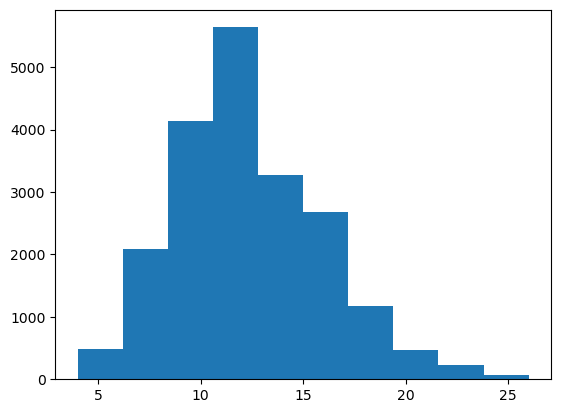

In [3]:
# plt.hist(passages_4['switch_index'])
# plt.show()
plt.hist(passages_35t['switch_index'])
plt.show()

In [3]:
passages_35t_sample = passages_35t.sample(10)
passages_35t_sample['prefix']

17827    First, let's try to factor the quadratic equat...
3379     First, let's try to factor the quadratic equat...
3630     To factor the quadratic equation 36x^2 - 1368x...
7225     To factor the quadratic equation 40x^2 - 1480x...
4080     To factor the quadratic equation 13x^2 - 598x ...
10528    To factor the quadratic equation 5x^2 - 25x + ...
1592     First, let's try to factor the quadratic equat...
11838    First, let's attempt to factor the quadratic e...
220      To factor the equation 5x^2 - 255x + 2890 = 0,...
13806    To factor the equation 1x^2 - 18x + 86 = 0, we...
Name: prefix, dtype: object

## 4. Assess 1t and COT CPC for prefixes

In [13]:
import concurrent.futures as futures
from solver import perform_one_token_cpc, perform_cot_cpc

def process_row(llm, row):
    row['cpc_one_token'] = perform_one_token_cpc(llm, row['prefix'])
    cot, answer = perform_cot_cpc(llm, row['prefix'])
    row['cpc_cot_thoughts'] = cot
    row['cpc_cot'] = answer
    return row

def experiment2(llm, passages: pd.DataFrame) -> pd.DataFrame:
    """
    Processes the rows in the given dataframe which have not already been processed.

    :dataframe: a dataframe with at least columns 'equation', 'difficulty', 'is_factorizable', and 'context'.
    Some rows may already have been processed, in which case they will have 'one_token_cpc_result' and 'cot_cpc_result'
    columns, or else a value in the 'error' column.
    :return: dataframe with the results of processing all rows in the given `passages` dataframe
    """
    # turn passages into a rows dict including index (id, numerical)
    rows = []
    try:
        with futures.ThreadPoolExecutor() as executor:
            row_futures = [executor.submit(process_row, llm, row) for row in passages.to_dict(orient='records')]
            for future in tqdm(futures.as_completed(row_futures), total=len(row_futures)):
                if future.exception():
                    print(f'Error processing row: {type(future.exception())} {str(future.exception())}')
                    continue
                rows.append(future.result())
    except Exception as e:
        print(f'Error processing rows: {type(e)} {str(e)}')
    finally:
        return pd.DataFrame(rows)

In [14]:
passages_35t_sample = passages_35t.sample(10)

test = experiment2(gpt35t, passages_35t_sample)
test.to_csv('gpt35t_experiment2_test.csv', index=False)

100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


In [15]:
test

,Unnamed: 0,prefix,difficulty,is_factorizable,context,equation,measured_switching,processed_switching,index,switch_index,cpc_one_token,cpc_cot_thoughts,cpc_cot
0,1450,"First, let's try to factor the quadratic equat...",30,Yes,"First, let's try to factor the quadratic equat...",10x^2 - 300x + 1760 = 0\n,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",6,13,Yes,"Upon analyzing the current approach, it seems ...",Yes
1,13836,"To factor the equation 15x^2 - 105x + 163 = 0,...",15,No,"To factor the equation 15x^2 - 105x + 163 = 0,...",15x^2 - 105x + 163 = 0\n,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,16,Yes,Let's revisit the approach used so far:\n\n1. ...,Yes
2,15369,"First, we will try to factor the quadratic equ...",15,Yes,"First, we will try to factor the quadratic equ...",3x^2 - 57x + 264 = 0\n,"[0, 0, 0, 0, 0, 0, 0]","[[0, 0, 0, 0, 0, 0, 0]]",0,7,Yes,The current approach of factoring the quadrati...,Yes
3,9611,"First, let's try to factor the quadratic equat...",30,No,"First, let's try to factor the quadratic equat...",12x^2 - 384x + 2800 = 0\n,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3,16,Yes,The current approach of factoring the quadrati...,Yes
4,6742,To factor the quadratic equation 24x^2 - 96x +...,25,No,To factor the quadratic equation 24x^2 - 96x +...,24x^2 - 96x + 74 = 0\n,"[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",14,21,Yes,Let's analyze the current approach we have tak...,Yes
5,15430,"First, let's try to factor the quadratic equat...",15,Yes,"First, let's try to factor the quadratic equat...",13x^2 - 299x + 1690 = 0\n,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",1,18,Yes,Let's analyze the current approach of factorin...,Yes
6,12530,To factor the quadratic equation 1x^2 - 19x + ...,10,No,To factor the quadratic equation 1x^2 - 19x + ...,1x^2 - 19x + 99 = 0\n,"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0]]",3,9,Yes,The current approach of factoring the quadrati...,Yes
7,15891,"First, let's try to factor the quadratic equat...",15,Yes,"First, let's try to factor the quadratic equat...",7x^2 - 140x + 525 = 0\n,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",5,13,Yes,Let's analyze the current approach:\n\nWe atte...,Yes
8,14535,"To factor the equation 2x^2 - 66x + 540 = 0, w...",25,Yes,"To factor the equation 2x^2 - 66x + 540 = 0, w...",2x^2 - 66x + 540 = 0\n,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]",0,10,Yes,Looking at the current approach of trying to f...,Yes
9,1024,To factor the quadratic equation 9x^2 - 333x +...,35,Yes,To factor the quadratic equation 9x^2 - 333x +...,9x^2 - 333x + 630 = 0\n,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,16,Yes,Let's analyze the current approach of factorin...,Yes


## 5. Save results and analyze